In [2]:
%matplotlib inline

In [3]:
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import os
from constant import DATA_DIR_PATH


In [4]:
bus_dataframe = pd.read_csv(os.path.join(DATA_DIR_PATH, 'bus_data.csv'))
gen_dataframe = pd.read_csv(os.path.join(DATA_DIR_PATH, 'gen_data.csv'))
branch_dataframe = pd.read_csv(os.path.join(DATA_DIR_PATH, 'branch_data.csv'))
loads_dataframe = pd.read_csv(os.path.join(DATA_DIR_PATH, 'load.csv'))
renewable_dataframe = pd.read_csv(os.path.join(DATA_DIR_PATH, 'renewable.csv'))

In [5]:
# constant
NG = 4
NT = 24
NN = 7
NS = 1
NA = 10
T = gp.tuplelist([t for t in range(1, 25)])

In [6]:
# gen data
G, L, l, RU, RD, P_min, P_max, S_max, SU, SD, a, b, c = gp.multidict({
    row['Gen_ID']: [
        row['Min_ON'],
        row['Min_OFF'],
        row['Ramp_Up_Rate'],
        row['Ramp_Down_Rate'],
        row['P_min'],
        row['P_max'],
        row['S_max'],
        row['Startup'],
        row['Shutdown'],
        row['Fuel_Cost_a'],
        row['Fuel_Cost_b'],
        row['Fuel_Cost_c']
    ] for _, row in gen_dataframe.iterrows()
})
b_ = gp.tupledict({g: b[g] * np.random.rand() for g in G})
a_ = gp.tupledict({g: a[g] * np.random.rand() for g in G})

In [7]:
A, BF, BT, F_max, B = gp.multidict({
    (row['From'], row['To']): [
        row['From'],
        row['To'],
        row['Flow_capacity'],
        row['Susceptance']
    ]
    for _, row in branch_dataframe.iterrows()
})  # NL

In [8]:
# bus data
N = set()
for _, row in bus_dataframe.iterrows():
    N.add(row['Bus_ID'])
N = sorted(gp.tuplelist(N))     # NN
GN = gp.tupledict({i: [] for i in N})   # NN
RN = gp.tupledict({})   # NR
P_cap = gp.tupledict({g: 0 for g in G})     # NG
RS = gp.tupledict({i: 0 for i in N})    # NN
for _, row in bus_dataframe.iterrows():
    if row.notnull().all():
        if row['Type'] == 'Wind':
            if row['Unit_ID'] not in RN:
                RN[row['Unit_ID']] = [row['Bus_ID']]
            else:
                RN[row['Unit_ID']].append(row['Bus_ID'])
        else:
            GN[row['Bus_ID']].append(row['Unit_ID'])
            P_cap[row['Unit_ID']] += row['Gen_Capacity']
        RS[row['Bus_ID']] += row['Spin_Reserve_Limits']

In [9]:
# load and renewable
D = gp.tupledict({(row['Bus_ID'], t): row[t] for _, row in loads_dataframe.iterrows() for t in T})
W = gp.tupledict({(i, t): 0 for i in N for t in T})
for _, row in renewable_dataframe.iterrows():
    for i in RN[row['Unit_ID']]:
        for t in range(1, 25):
            W[(i, t)] += row[t]
VOLL = 10.0

In [10]:
# model
m = gp.Model()
u = m.addVars(G, T, vtype=GRB.BINARY, name='u')
v = m.addVars(G, T, vtype=GRB.BINARY, name='v')
w = m.addVars(G, T, vtype=GRB.BINARY, name='w')
p = m.addVars(G, T, name='p', lb=0)
s = m.addVars(G, T, name='s', lb=0, ub=S_max)
f = m.addVars(A, T, name="f")
delta = m.addVars(N, T, name='delta', lb=0)
beta = m.addVars(N, T, name='beta')

obj = v.prod(SU, '*', '*') + w.prod(SD, '*', '*')
obj += p.prod(b, '*', '*') + u.prod(a, '*', '*') + s.prod(b_, '*', '*') + u.prod(a_, '*', '*')
obj += VOLL * delta.sum('*', '*')
m.setObjective(obj)

Academic license - for non-commercial use only - expires 2022-07-18
Using license file C:\Users\ms303\gurobi.lic


In [11]:
m.addConstrs((u[g, t] - u[g, t - 1] <= u[g, tau]
                  for g in G for t in range(2, NT + 1) for tau in range(t, min(t + L[g] - 1, NT + 1))), name='Startup')
m.addConstrs((u[g, t - 1] - u[g, t] <= 1 - u[g, tau]
              for g in G for t in range(2, NT + 1) for tau in range(t, min(t + l[g] - 1, NT + 1))), name='Shutdown')
m.addConstrs((v[g, t] >= u[g, t] - u[g, t - 1]
              for g in G for t in range(2, NT + 1)), name='startup_indicator')
m.addConstrs((w[g, t] >= -u[g, t] + u[g, t - 1] for g in G for t in range(2, NT + 1)), name='shutdown_indicator')
m.addConstrs((P_min[g] * u[g, t] <= p[g, t] for g in G for t in T), name='generation_upper')
m.addConstrs((p[g, t] <= P_max[g] * u[g, t] for g in G for t in T), name='generation_lower')
m.addConstrs((-RD[g] <= p[g, t] - p[g, t - 1] for g in G for t in range(2, NT + 1)), name='ramp_up')
m.addConstrs((p[g, t] - p[g, t - 1] <= RU[g] for g in G for t in range(2, NT + 1)), name='ramp_down')
m.addConstrs((p[g, t] + s[g, t] <= P_cap[g] * u[g, t] for g in G for t in T), name='reserve_limit')
m.addConstrs((s.sum(GN[i], t) >= RS[i] for i in N for t in T), name='reserve_bus')
m.addConstrs((f.sum(i, '*', t) - f.sum('*', i, t) - p.sum(GN[i], t) - s.sum(GN[i], t) - delta[i, t]
              == W[i, t] - D[i, t] for i in N for t in T), name='balance')
m.addConstrs((f[i, j, t] - B[i, j] * (beta[i, t] - beta[j, t]) == 0 for i, j in A for t in T))

{('B1', 'B2', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('B1', 'B2', 2): <gurobi.Constr *Awaiting Model Update*>,
 ('B1', 'B2', 3): <gurobi.Constr *Awaiting Model Update*>,
 ('B1', 'B2', 4): <gurobi.Constr *Awaiting Model Update*>,
 ('B1', 'B2', 5): <gurobi.Constr *Awaiting Model Update*>,
 ('B1', 'B2', 6): <gurobi.Constr *Awaiting Model Update*>,
 ('B1', 'B2', 7): <gurobi.Constr *Awaiting Model Update*>,
 ('B1', 'B2', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('B1', 'B2', 9): <gurobi.Constr *Awaiting Model Update*>,
 ('B1', 'B2', 10): <gurobi.Constr *Awaiting Model Update*>,
 ('B1', 'B2', 11): <gurobi.Constr *Awaiting Model Update*>,
 ('B1', 'B2', 12): <gurobi.Constr *Awaiting Model Update*>,
 ('B1', 'B2', 13): <gurobi.Constr *Awaiting Model Update*>,
 ('B1', 'B2', 14): <gurobi.Constr *Awaiting Model Update*>,
 ('B1', 'B2', 15): <gurobi.Constr *Awaiting Model Update*>,
 ('B1', 'B2', 16): <gurobi.Constr *Awaiting Model Update*>,
 ('B1', 'B2', 17): <gurobi.Constr *Awaiting Model

In [12]:
m.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1370 rows, 1056 columns and 3386 nonzeros
Model fingerprint: 0x09a555db
Variable types: 768 continuous, 288 integer (288 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+01, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 658 rows and 528 columns
Presolve time: 0.01s
Presolved: 712 rows, 528 columns, 2280 nonzeros
Variable types: 432 continuous, 96 integer (96 binary)

Root relaxation: objective 1.154970e+03, 505 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1154.96970    0    6          - 1154.96970      -     -    0s
H    0     0                    1286.9230769 1154.96970  10.3%     -    0s
     0     0 1162

1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 
0 1 1 0 0 0 1 0 1 1 1 1 0 1 1 0 0 1 1 0 0 1 1 1 


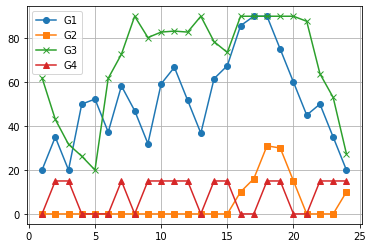

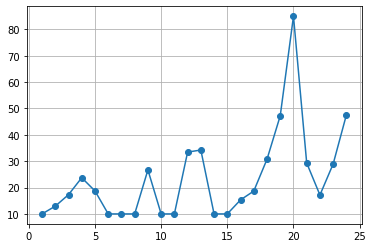

In [18]:
import matplotlib.pyplot as plt
u_val = m.getAttr('x', u)
p_val = m.getAttr('x', p)
s_val = m.getAttr('x', s)
for g in G:
    u_s = ''
    for t in T:
        u_s += str(int(u_val[g, t])) + ' '
    print(u_s)
p_real_patterns = ['o-', 's-', 'x-', '^-']
for pattern, g in zip(p_real_patterns, G):
    plt.plot(T, [p_val[g, t] * u_val[g, t] for t in T], pattern, label=g)
plt.legend()
plt.grid(True)
plt.show()
plt.plot(T, [sum([s_val[g, t] for g in G]) for t in T], 'o-')
plt.grid(True)
plt.show()